It has been a while since I have wanted to start this project, yet every time I have delayed writing it up for some reason or another. It is finally time to figure this bad boy out once and for all. I still need to learn theory but we can start by implementing the MC sampling algorithm and see how it does in this simple setting. SIKE -> after watching lecture 10 seems like tree strap is a much easier beginning. We will start with the surefire minimax and then add in treestrap on top of a minimax search

Add feature for input type 

In [1]:
import numpy as np
from enum import Enum
from __future__ import annotations

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import pygame
from pygame.locals import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Plan 

Environment: 
- step(a, player[ENUM]) => state, reward, done, mask 
- reset() => state
- get_internal() => internal_dict: state, reward, terminal, mask, moves_left 
- set_internal(internal_dict)
- render()


In [2]:
class Player(Enum):
    X = 1.0
    O = -1.0
    
    def other(player : Player) -> Player: 
        if player == Player.X:
            return Player.O
        else: 
            return Player.X
        
turn_to_player = {0 : Player.X, 1: Player.O}

class BG: 
    
    def __init__(self):
        self.reset()
        
    def step(self, a : int, player : Player) -> List[np.array, int, bool, np.array]:
        
        if self.state[a] != 0: 
            raise ValueError('invalid move!', self.get_internal())
            
        self.state[a] = player.value
        self.game_state[0][a + (9 if player == Player.O else 0)] = 1
        self.mask[a] = 0
        self.moves_left -= 1
        self.actions_taken.append(a)
        
        if self.moves_left < 5: 
            
            temp = a//3 * 3
            if abs(self.state[temp] + self.state[temp+1] + self.state[temp+2]) == 3:
                self.done = True
                self.reward = 1 * player.value

            
            elif abs(self.state[a] + self.state[(a+3)%9] + self.state[(a+6)%9]) == 3:
                self.done = True
                self.reward = 1 * player.value

            elif a%2 == 0 and \
                (abs(self.state[0] + self.state[4] + self.state[8]) == 3 \
                or abs(self.state[2] + self.state[4] + self.state[6]) == 3):
                self.done = True
                self.reward = 1 * player.value
                            
            elif self.moves_left == 0:
                self.done = True
                self.reward = 0  
                
        return self.game_state, self.reward, self.done, self.mask
    
    def undo(self): 
        if len(self.actions_taken) == 0:
            raise ValueError('no actions taken yet', self.get_internal())
        
        recent_action = self.actions_taken.pop()
        self.game_state[0][[recent_action, recent_action + 9]] = 0
        self.state[recent_action] = 0
        self.mask[recent_action] = 1
        self.moves_left += 1
        self.done = False
        self.reward = 0
                
    def reset(self) -> List[np.array, int, bool, np.array]:
        self.set_internal({})
        return self.game_state, self.reward, self.done, self.mask
    
    def calculate_turn(self) -> int: 
        return 1 - self.moves_left % 2 
    
    def get_obs(self) -> List[np.array, int, bool, np.array]:
        return self.game_state, self.reward, self.done, self.mask
        
    def get_internal(self) -> Dict:
        return {'game_state' : self.game_state,
                'state' : self.state, 
                'mask' : self.mask, 
                'reward' : self.reward, 
                'done' : self.done, 
                'moves_left' : self.moves_left,
                'actions_taken' : self.actions_taken}
    
    def set_internal(self, internal_dict : Dict):
        self.game_state = internal_dict.get('game_state', np.zeros((1, 18)))
        self.state = internal_dict.get('state', np.zeros(9))
        self.mask = internal_dict.get('mask', np.ones(9))
        
        self.reward = internal_dict.get('reward', 0)
        self.done = internal_dict.get('done', False)
        
        self.moves_left = internal_dict.get('moves_left', 9)
        self.actions_taken = internal_dict.get('actions_taken', [])
        
    def render(self):
        conv = {-1 : 'O', 0 : ' ', 1 : 'X'}
        temp = self.state.reshape(3, 3).astype(np.int)
        
        lines = ['|'.join(conv[v] for v in row) for row in temp]
        board = '\n-----\n'.join(lines)
        print(board, end="\n\n")
        
    def close(self):
        pass

In [3]:
class Human:
    
    def __init__(self, player): 
        self.player = player
        
    def choose_action(self, env):
        return int(input("Take an action please: "))

In [4]:
class RandomBot: 
    def __init__(self, player):
        self.player = player
    
    def evaluate(self, env):
        return "IS A RANDOM BOT"
    
    def choose_action(self, env):
        return (np.random.uniform(low = 0.5, high = 1, size=[9]) * env.mask).argmax()

In [5]:
inputs = keras.Input(shape=(18,), name="inp")
x = layers.Dense(50, activation="relu", name="layer_1")(inputs)
x = layers.Dense(50, activation="relu", name="layer_2")(x)
x = layers.Dense(25, activation="relu", name="layer_3")(x)
outputs = layers.Dense(1, activation="tanh", name="value")(x)
value_network = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
value_network = keras.models.load_model("epsilon_good_net5000")

In [7]:
class Minimax:
    
    def __init__(self, player, max_depth = 3, debug = False, training = True, epsilon=0.9, decay=0.9999, min_epsilon=0.15, explore = True):
        self.player = player 
        self.value = 0
        self.e = BG()
        self.max_depth = max_depth
        
        self.states = []
        self.rewards = []
        
        self.loss_fn = keras.losses.MSE
        self.optimizer = keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0003, name="SGD")
        self.loss_h = []
        self.episode_loss = []
        
        self.epsilon = epsilon
        self.decay = decay
        self.min_epsilon = min_epsilon
        self.explore = explore
        
        self.debug = debug
        self.training = training
        
    def choose_action(self, env):
        
        self.e.set_internal(env.get_internal())        
        
        if self.player == Player.X: 
            a = self.max_expand(self.max_depth)[0]
        else: 
            a = self.min_expand(self.max_depth)[0]
        
        if self.training: 
            r = tf.expand_dims(tf.stack(self.rewards), axis = 1)
            
            l = self.update(tf.stack(self.states), r)
            self.states, self.rewards = [], []
            self.episode_loss.append(tf.math.reduce_mean(l))
            
        if self.explore:      
            if self.epsilon > self.min_epsilon:
                self.epsilon*=self.decay

            if np.random.rand() < self.epsilon:
                p = np.random.uniform(size=(9))
                p*= env.mask
                a = int(p.argmax())
        
        return a
        
    def evaluate(self, s): 
        return tf.squeeze(value_network(s))
            
    def max_expand(self, depth):
        
        if depth == 0: return -1, self.evaluate(self.e.game_state)
        
        info = []
        
        for a in self.e.mask.nonzero()[0]:
            s, r, d, m = self.e.step(a, turn_to_player[self.e.calculate_turn()])
            
            if d: info.append((a, r))  
            else: info.append((a, self.min_expand(depth-1)[1])) 
                
            self.e.undo()
            
        action, max_reward = max(info, key = lambda x : x[1])
        possibilities = [(x, y) for x,y in info if y == max_reward]
        self.add_update(self.e.game_state, max_reward)
        
        if self.debug and depth == self.max_depth:
            print([(x, float(y)) for x, y in info])

        return action, max_reward
    
    def min_expand(self, depth):
        
        if depth == 0: return -1, self.evaluate(self.e.game_state)
        
        info = []
        
        for a in self.e.mask.nonzero()[0]:
            s, r, d, m = self.e.step(a, turn_to_player[self.e.calculate_turn()])

            if d: info.append((a, r))                
            else: info.append((a, self.max_expand(depth-1)[1]))
                
            self.e.undo()
            
          
        action, min_reward = min(info, key = lambda x : x[1])
        self.add_update(self.e.game_state, min_reward)

        if self.debug and depth == self.max_depth:
            print([(x, float(y)) for x, y in info])
        return action, min_reward
    
    @tf.function()
    def update(self, s, r):
        
        with tf.GradientTape() as tape:
            r_pred = value_network(s)
            loss = tf.norm(self.loss_fn(r, r_pred))
            
        gradient = tape.gradient(loss, value_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradient, value_network.trainable_weights))
        
        return loss
        
    def reset_metric(self):
        if len(self.episode_loss) > 0:
            self.loss_h.append(np.mean(self.episode_loss))
            self.episode_loss = []
            
    def add_update(self, s, r):        
        self.states.append(tf.squeeze(s))
        self.rewards.append(r)

In [8]:
class Strategy:
    def __init__(self):
        self.all_strats = set()
        
    def add_strat(self, move_list):
        tot = 0
        for i,a in enumerate(move_list):
            tot += 10**i * a
            
        self.all_strats.add(tot)
        
    @property
    def get_total(self):
        return len(self.all_strats)

In [11]:
import time 
start = time.time()

agents = [Minimax(Player.X, max_depth = 3), Minimax(Player.O, max_depth = 3)]
games = 5000

strats = Strategy()

for g in range(1, games+1):
    
    env = BG()
    s, r, d, m = env.reset()
    
    index = 0

    while not d: 
        #print(f"Player {agents[index].__class__} {agents[index].player} turn")
        a = agents[index].choose_action(env)
        s, r, d, m = env.step(a, agents[index].player)
        #env.render()

        index = 1 - index
        
    agents[0].reset_metric()
    agents[1].reset_metric()

    strats.add_strat(env.actions_taken)
    
    if g % 10 == 0: 
        l = (sum(agents[0].loss_h[-10:]) + sum(agents[1].loss_h[-10:]))/20
        print(f"Game number {g} completed in {time.time() - start} seconds with total loss {l}")
        print(f"{strats.get_total} strategies were explored with an exploration rate of {agents[0].epsilon}")

print(time.time() - start)

Game number 10 completed in 9.85136342048645 seconds with total loss 2.05171460211277
10 strategies were explored with an exploration rate of 0.8964070111162198
Game number 20 completed in 17.7414972782135 seconds with total loss 2.284701979160309
20 strategies were explored with an exploration rate of 0.892649809453171
Game number 30 completed in 25.33602547645569 seconds with total loss 2.3737392902374266
30 strategies were explored with an exploration rate of 0.8892640079816001
Game number 40 completed in 33.288525342941284 seconds with total loss 1.7389483332633973
40 strategies were explored with an exploration rate of 0.8852711110539446
Game number 50 completed in 41.38364553451538 seconds with total loss 2.006045562773943
50 strategies were explored with an exploration rate of 0.8814724283603314
Game number 60 completed in 49.202014207839966 seconds with total loss 1.9240258157253265
60 strategies were explored with an exploration rate of 0.8776022767424543
Game number 70 comple

Game number 470 completed in 344.9532632827759 seconds with total loss 1.5014955163002015
466 strategies were explored with an exploration rate of 0.742843334883492
Game number 480 completed in 351.95090651512146 seconds with total loss 1.5782701969146729
476 strategies were explored with an exploration rate of 0.7398777483894622
Game number 490 completed in 359.0413203239441 seconds with total loss 1.3311987668275833
486 strategies were explored with an exploration rate of 0.7367029460457484
Game number 500 completed in 365.9976556301117 seconds with total loss 1.3791417211294175
496 strategies were explored with an exploration rate of 0.733248394025671
Game number 510 completed in 373.0151159763336 seconds with total loss 1.43775355219841
506 strategies were explored with an exploration rate of 0.7301750556299456
Game number 520 completed in 379.92078495025635 seconds with total loss 1.390764319896698
516 strategies were explored with an exploration rate of 0.7272600435653988
Game nu

Game number 970 completed in 746.2532348632812 seconds with total loss 1.2392573326826095
952 strategies were explored with an exploration rate of 0.6053307071058865
Game number 980 completed in 753.9263200759888 seconds with total loss 1.0675189912319183
961 strategies were explored with an exploration rate of 0.6026127031172794
Game number 990 completed in 761.9695432186127 seconds with total loss 1.260574886202812
971 strategies were explored with an exploration rate of 0.6004470895469797
Game number 1000 completed in 769.9607992172241 seconds with total loss 1.1953599125146865
980 strategies were explored with an exploration rate of 0.5981696066887984
Game number 1010 completed in 778.6906957626343 seconds with total loss 1.0808906883001328
989 strategies were explored with an exploration rate of 0.5958411721977422
Game number 1020 completed in 785.7316653728485 seconds with total loss 1.1323715224862099
998 strategies were explored with an exploration rate of 0.5936405235370643
Ga

Game number 1460 completed in 1135.9645476341248 seconds with total loss 1.036261460185051
1387 strategies were explored with an exploration rate of 0.49644118454691977
Game number 1470 completed in 1143.1056106090546 seconds with total loss 1.0447117581963539
1396 strategies were explored with an exploration rate of 0.49440984122095166
Game number 1480 completed in 1150.1170563697815 seconds with total loss 0.8394294194877148
1403 strategies were explored with an exploration rate of 0.49223910849542013
Game number 1490 completed in 1157.0939407348633 seconds with total loss 1.073044988512993
1413 strategies were explored with an exploration rate of 0.49012691917938683
Game number 1500 completed in 1164.0314328670502 seconds with total loss 0.8730667263269425
1423 strategies were explored with an exploration rate of 0.4882190515598172
Game number 1510 completed in 1170.9901292324066 seconds with total loss 0.9932529509067536
1432 strategies were explored with an exploration rate of 0.4

Game number 1950 completed in 1555.7235283851624 seconds with total loss 0.8712817266583442
1774 strategies were explored with an exploration rate of 0.404299019173487
Game number 1960 completed in 1565.8629686832428 seconds with total loss 0.858348871767521
1782 strategies were explored with an exploration rate of 0.4027655217150485
Game number 1970 completed in 1577.0837473869324 seconds with total loss 0.6779641315340996
1789 strategies were explored with an exploration rate of 0.4009570585367492
Game number 1980 completed in 1587.8371484279633 seconds with total loss 0.6966237857937813
1797 strategies were explored with an exploration rate of 0.3993164181744838
Game number 1990 completed in 1598.5949659347534 seconds with total loss 0.6981629744172096
1804 strategies were explored with an exploration rate of 0.39752344186488353
Game number 2000 completed in 1609.3280186653137 seconds with total loss 0.5925506219267845
1812 strategies were explored with an exploration rate of 0.3956

Game number 2440 completed in 2082.775502681732 seconds with total loss 0.7741401694715023
2076 strategies were explored with an exploration rate of 0.33014918233201546
Game number 2450 completed in 2093.5383677482605 seconds with total loss 0.6076101452112198
2082 strategies were explored with an exploration rate of 0.3287982743917001
Game number 2460 completed in 2104.323798894882 seconds with total loss 0.7424820303916931
2088 strategies were explored with an exploration rate of 0.32748564267514946
Game number 2470 completed in 2114.934173345566 seconds with total loss 0.6519868932664394
2096 strategies were explored with an exploration rate of 0.3260804075695379
Game number 2480 completed in 2125.7122445106506 seconds with total loss 0.5689033217728138
2102 strategies were explored with an exploration rate of 0.32464873418270185
Game number 2490 completed in 2136.490528821945 seconds with total loss 0.5721254363656044
2107 strategies were explored with an exploration rate of 0.3232

Game number 2930 completed in 2623.0526719093323 seconds with total loss 0.42849722430109977
2303 strategies were explored with an exploration rate of 0.2686029600432822
Game number 2940 completed in 2633.97288441658 seconds with total loss 0.41584568843245506
2306 strategies were explored with an exploration rate of 0.2673434253784668
Game number 2950 completed in 2645.209620475769 seconds with total loss 0.34032911211252215
2310 strategies were explored with an exploration rate of 0.2661430228745518
Game number 2960 completed in 2656.2331392765045 seconds with total loss 0.4068708911538124
2315 strategies were explored with an exploration rate of 0.26497450776571224
Game number 2970 completed in 2666.9829666614532 seconds with total loss 0.38934386894106865
2322 strategies were explored with an exploration rate of 0.2638638932246643
Game number 2980 completed in 2677.6482248306274 seconds with total loss 0.38845999278128146
2322 strategies were explored with an exploration rate of 0.

Game number 3420 completed in 3191.2770552635193 seconds with total loss 0.28876030892133714
2440 strategies were explored with an exploration rate of 0.21730973989220953
Game number 3430 completed in 3198.9695076942444 seconds with total loss 0.23363870568573475
2442 strategies were explored with an exploration rate of 0.21644219380357624
Game number 3440 completed in 3206.9018297195435 seconds with total loss 0.1990511853247881
2444 strategies were explored with an exploration rate of 0.21549189283036949
Game number 3450 completed in 3214.751481771469 seconds with total loss 0.20981490947306156
2446 strategies were explored with an exploration rate of 0.21456722092626315
Game number 3460 completed in 3222.854291677475 seconds with total loss 0.19047650173306466
2448 strategies were explored with an exploration rate of 0.21351836090559825
Game number 3470 completed in 3231.172473669052 seconds with total loss 0.294950070604682
2449 strategies were explored with an exploration rate of 

Game number 3910 completed in 3686.1251652240753 seconds with total loss 0.2274445801973343
2549 strategies were explored with an exploration rate of 0.17472491150132277
Game number 3920 completed in 3693.9898562431335 seconds with total loss 0.329318792745471
2551 strategies were explored with an exploration rate of 0.17390559036350942
Game number 3930 completed in 3701.9304683208466 seconds with total loss 0.32457045242190363
2554 strategies were explored with an exploration rate of 0.17314204861194815
Game number 3940 completed in 3709.838301420212 seconds with total loss 0.21245211362838745
2555 strategies were explored with an exploration rate of 0.17231291682962038
Game number 3950 completed in 3717.695582151413 seconds with total loss 0.16274898126721382
2556 strategies were explored with an exploration rate of 0.17152205823799274
Game number 3960 completed in 3725.502264738083 seconds with total loss 0.309716010093689
2560 strategies were explored with an exploration rate of 0.

Game number 4400 completed in 4158.0884346961975 seconds with total loss 0.7259138241410256
2645 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4410 completed in 4167.977702379227 seconds with total loss 0.44546606130898
2647 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4420 completed in 4178.391187906265 seconds with total loss 0.2362911246716976
2648 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4430 completed in 4188.639376878738 seconds with total loss 0.13676571995019912
2648 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4440 completed in 4199.2345662117 seconds with total loss 0.26361405849456787
2650 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4450 completed in 4208.0580224990845 seconds with total loss 0.13131762202829123
2651 strategies were explored with an exploration rate of 0.149

Game number 4890 completed in 4648.659229516983 seconds with total loss 0.44177092537283896
2709 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4900 completed in 4658.963869571686 seconds with total loss 0.18763784915208817
2709 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4910 completed in 4669.111378669739 seconds with total loss 0.17946300953626632
2709 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4920 completed in 4679.525584459305 seconds with total loss 0.2153186745941639
2710 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4930 completed in 4689.971220254898 seconds with total loss 0.17570740040391683
2712 strategies were explored with an exploration rate of 0.14999548180636801
Game number 4940 completed in 4700.121260404587 seconds with total loss 0.11130333766341209
2712 strategies were explored with an exploration rate of 0

In [57]:
used_strats = list(set(strats.all_strats))

In [9]:
e = BG()
p = [Player.X, Player.O]
i = 0

for l in used_strats:
    l = str(l)
    for c in l: 
        e.step(int(c), p[i])
        i = 1-i
    e.render()
    e.reset()

NameError: name 'used_strats' is not defined

In [10]:
m = Minimax(Player.X, max_depth = 3, training = False, debug = True, explore = False)
e = BG()
m.choose_action(e)

[(0, 0.3929505944252014), (1, 0.3929505944252014), (2, 0.07110754400491714), (3, -0.02802792750298977), (4, 0.2469054013490677), (5, -0.1680048108100891), (6, 0.022360941395163536), (7, -0.05789629742503166), (8, -0.010488195344805717)]


0

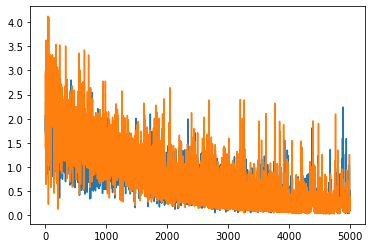

In [12]:
x = agents[0].loss_h
x2 = agents[1].loss_h

plt.plot(np.arange(len(x)), x)
plt.plot(np.arange(len(x2)), x2)

In [9]:
value_network = keras.models.load_model("larger_value_net")

In [ ]:
r_pred.shape

In [27]:
tf.expand_dims(r, axis = 1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-1.],
       [-1.],
       [-1.]], dtype=float32)>

In [136]:
t = tf.keras.models.load_model('model1')

In [153]:
value_network = USE_LATE

In [142]:
value_network = t

In [158]:
value_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 18)]              0         
_________________________________________________________________
layer_1 (Dense)              (None, 50)                950       
_________________________________________________________________
layer_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
value (Dense)                (None, 1)                 26        
Total params: 2,251
Trainable params: 2,251
Non-trainable params: 0
_________________________________________________________________


In [154]:
test = BG()
test.step(6, Player.X)
test.step(4, Player.O)
test.step(8, Player.X)
#test.step(0, Player.O)

m2 = Minimax(Player.O, max_depth = 1, debug = True, training = False)
m = Minimax(Player.O, max_depth = 2, debug = True, training = False)

test.render()

m2.choose_action(test)
m.choose_action(test)

 | | 
-----
 |O| 
-----
X| |X

[(0, nan), (1, nan), (2, nan), (3, nan), (5, nan), (7, nan)]
[(0, nan), (1, nan), (2, nan), (3, nan), (5, nan), (7, nan)]


0

In [27]:
m = agents2[1]
type(m)

__main__.Minimax

In [28]:
m.states

[<tf.Tensor: shape=(18,), dtype=float64, numpy=
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0.])>,
 <tf.Tensor: shape=(18,), dtype=float64, numpy=
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0.])>,
 <tf.Tensor: shape=(18,), dtype=float64, numpy=
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0.])>]

In [24]:
s, r

(<tf.Tensor: shape=(3, 18), dtype=float64, numpy=
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
         0., 0.]])>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[-0.99413484],
        [-0.99961734],
        [-0.9999187 ]], dtype=float32)>)

In [23]:
s = tf.stack(m.states)
r = tf.expand_dims(tf.stack(m.rewards), axis = 1)

with tf.GradientTape() as tape:
    r_pred = value_network(s)
    loss = tf.norm(keras.losses.MSE(r, r_pred))
        
#print(loss, r_pred, r)
gradient2 = tape.gradient(loss, value_network.trainable_weights)
#m.optimizer.apply_gradients(zip(gradient, value_network.trainable_weights))

print(loss)

tf.Tensor(0.008788705, shape=(), dtype=float32)


In [104]:

with tf.GradientTape() as tape:
    r_pred = value_network(s)
    loss = m.loss_fn(r, r_pred)
    
print(loss)   

tf.Tensor([1.7195134e-10], shape=(1,), dtype=float32)


In [18]:
print(agents[0].update.pretty_printed_concrete_signatures())

update(s, r)
  Args:
    s: float64 Tensor, shape=(82, 18)
    r: float32 Tensor, shape=(82,)
  Returns:
    float32 Tensor, shape=(82,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(22, 18)
    r: float32 Tensor, shape=(22,)
  Returns:
    float32 Tensor, shape=(22,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(50, 18)
    r: float32 Tensor, shape=(50,)
  Returns:
    float32 Tensor, shape=(50,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(10, 18)
    r: float32 Tensor, shape=(10,)
  Returns:
    float32 Tensor, shape=(10,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(82, 18)
    r: float32 Tensor, shape=(82,)
  Returns:
    float32 Tensor, shape=(82,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(1, 18)
    r: int32 Tensor, shape=(1,)
  Returns:
    float32 Tensor, shape=(1,)

update(s, r)
  Args:
    s: float64 Tensor, shape=(8, 18)
    r: float32 Tensor, shape=(8,)
  Returns:
    float32 Tensor, shape=(8,)


In [39]:
e = BG()
e.step(3, Player.X)
e.step(4, Player.O)
e.step(0, Player.X)
e.step(1, Player.O)

print(value_network(e.game_state))
e.render()

print(Minimax(Player.X, max_depth = 1, debug = True, training = False, explore = False).choose_action(e))
print(Minimax(Player.X, max_depth = 6, debug = True, training = False, explore = False).choose_action(e))

tf.Tensor([[-0.7653072]], shape=(1, 1), dtype=float32)
X|O| 
-----
X|O| 
-----
 | | 

[(2, -0.9972026348114014), (5, -0.9897016882896423), (6, 1.0), (7, -0.9968457818031311), (8, -0.9954777956008911)]
6
[(2, -1.0), (5, -1.0), (6, 1.0), (7, 0.0), (8, -1.0)]
6


In [14]:
agents2 = [Minimax(Player.X, max_depth = 1, debug = True, explore = False, training = False), 
           Minimax(Player.O, max_depth = 1, debug = True, explore = False, training = False)]
#agents2 = [Human(Player.X), Minimax(Player.O, max_depth = 1, debug = True, training = False, explore = False)]
#agents2 = [RandomBot(Player.X), Minimax(Player.O, max_depth = 1, debug = True, training = False, explore = False)]
    
env = BG()
s, r, d, m = env.reset()

#env.step(0, Player.X)   #

#index = 1    #
index = 0

while not d: 
    print(f"Player {agents2[index].__class__} {agents2[index].player} turn")
    a = agents2[index].choose_action(env)
    s, r, d, m = env.step(a, agents2[index].player)
    env.render()
    
    index = 1 - index

Player <class '__main__.Minimax'> Player.X turn
[(0, 0.1627739816904068), (1, 0.08172322809696198), (2, -0.04083317518234253), (3, -0.26001784205436707), (4, 0.26637932658195496), (5, -0.19680044054985046), (6, 0.10193490982055664), (7, -0.1815129518508911), (8, -0.0024103287141770124)]
 | | 
-----
 |X| 
-----
 | | 

Player <class '__main__.Minimax'> Player.O turn
[(0, 0.9611228108406067), (1, 0.8898664712905884), (2, 0.8822572231292725), (3, 0.8105031251907349), (5, 0.983535885810852), (6, 0.8679623603820801), (7, 0.9558358788490295), (8, 0.37650495767593384)]
 | | 
-----
 |X| 
-----
 | |O

Player <class '__main__.Minimax'> Player.X turn
[(0, 0.17581771314144135), (1, 0.2469054013490677), (2, 0.1729261726140976), (3, -0.032016970217227936), (5, 0.21819420158863068), (6, 0.2091735601425171), (7, 0.17156630754470825)]
 |X| 
-----
 |X| 
-----
 | |O

Player <class '__main__.Minimax'> Player.O turn
[(0, 0.9931862950325012), (2, 0.9570872783660889), (3, 0.9548094272613525), (5, 0.9705055952

In [10]:
import time 
start = time.time()

#agents2 = [Minimax(Player.X, max_depth = 3, debug = True, explore = False, training = False), 
 #          Minimax(Player.O, max_depth = 3, debug = True, explore = False, training = False)]
agents2 = [Minimax(Player.X, max_depth = 1, debug = True, training = False, explore = False), Human(Player.O)]
#agents2 = [RandomBot(Player.X), Minimax(Player.O, max_depth = 1, debug = True, training = False, explore = False)]
    
env = BG()
s, r, d, m = env.reset()

#env.step(0, Player.X)   #

#index = 1    #
index = 0

while not d: 
    print(f"Player {agents2[index].__class__} {agents2[index].player} turn")
    a = agents2[index].choose_action(env)
    s, r, d, m = env.step(a, agents2[index].player)
    env.render()
    
    index = 1 - index

print(time.time() - start)

Player <class '__main__.Minimax'> Player.X turn
[(0, 0.1627739816904068), (1, 0.08172322809696198), (2, -0.04083317518234253), (3, -0.26001784205436707), (4, 0.26637932658195496), (5, -0.19680044054985046), (6, 0.10193490982055664), (7, -0.1815129518508911), (8, -0.0024103287141770124)]
 | | 
-----
 |X| 
-----
 | | 

Player <class '__main__.Human'> Player.O turn
Take an action please: 0
O| | 
-----
 |X| 
-----
 | | 

Player <class '__main__.Minimax'> Player.X turn
[(1, 0.8334336280822754), (2, 0.8249943852424622), (3, 0.7283322215080261), (5, 0.45005443692207336), (6, 0.7693401575088501), (7, 0.3870547115802765), (8, 0.5855384469032288)]
O|X| 
-----
 |X| 
-----
 | | 

Player <class '__main__.Human'> Player.O turn
Take an action please: 7
O|X| 
-----
 |X| 
-----
 |O| 

Player <class '__main__.Minimax'> Player.X turn
[(2, 0.5379315614700317), (3, 0.810063362121582), (5, 0.009353315457701683), (6, 0.9132905602455139), (8, 0.5674870610237122)]
O|X| 
-----
 |X| 
-----
X|O| 

Player <class '

In [19]:
def simulate(n = 100):
    env = BG()
    
    records = [0, 0, 0]
    for _ in range(n):
        s, r, d, m = env.reset()
        
        #agents = [Minimax(Player.X, max_depth = 1, debug = False, training = False, explore = False), RandomBot(Player.O)]
        agents = [RandomBot(Player.X), Minimax(Player.O, max_depth = 1, debug = False, training = False, explore = False)]

        index = 0

        while not d: 
            a = agents[index].choose_action(env)
            s, r, d, m = env.step(a, agents[index].player)

            index = 1 - index

        records[int(r + 1)] += 1
        print(f"{_+1} games passed    ", end = '\r')
    return records
    

In [20]:
simulate()

[89, 11, 0]

In [30]:
value_network.save("larger_value_net")

INFO:tensorflow:Assets written to: larger_value_net\assets


In [11]:
env = BG()
env.step(0, Player.X)
env.step(1, Player.O)


env.render()


m_agent = Minimax(Player.X, debug = True, training = False)

a = m_agent.choose_action(env)
env.step(a, m_agent.player)
env.render()

X|O| 
-----
 | | 
-----
 | | 

[(2, -0.9999363422393799), (3, 0.9999933242797852), (4, 1.0), (5, -0.9999459385871887), (6, 0.9992682933807373), (7, -0.9999882578849792), (8, -0.9999363422393799)]
X|O| 
-----
 |X| 
-----
 | | 



In [5]:
def simulate(n = 100):
    env = BG()
    
    records = [0, 0, 0]
    for _ in range(n):
        s, r, d, m = env.reset()
        
        agents = [RandomBot(Player.X), RandomBot(Player.O)] #[RandomBot(Player.X), Minimax(Player.O, max_depth = 4)]
        index = 0

        while not d: 
            a = agents[index].choose_action(env)
            s, r, d, m = env.step(a, agents[index].player)

            index = 1 - index

        records[int(r + 1)] += 1
                
    return records
    

In [8]:
simulate(10000)

[2916, 1328, 5756]

In [11]:
env = BG()
s, _, d, m = env.reset()

agents = [RandomBot(Player.X), Minimax(Player.O, max_depth = 4)]
index = env.calculate_turn()

while not d: 
    a = agents[index].choose_action(env)
    s, _, d, m = env.step(a, agents[index].player)
    
    print(env.get_internal())
    env.render()
    print()
    index = 1 - index
    
print(_)

{'game_state': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]]), 'state': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mask': array([0., 1., 1., 1., 1., 1., 1., 1., 1.]), 'reward': 0, 'done': False, 'moves_left': 8, 'actions_taken': [0]}
X| | 
-----
 | | 
-----
 | | 


{'game_state': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.]]), 'state': array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]), 'mask': array([0., 1., 1., 1., 1., 1., 1., 1., 0.]), 'reward': 0, 'done': False, 'moves_left': 7, 'actions_taken': [0, 8]}
X| | 
-----
 | | 
-----
 | |O


{'game_state': array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.]]), 'state': array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.]), 'mask': array([0., 1., 1., 1., 1., 0., 1., 1., 0.]), 'reward': 0, 'done': False, 'moves_left': 6, 'actions_taken': [0, 8, 5]}
X| | 
-----
 | |X
-----
 | |O


{'game_state': array([[1., 0., 0., 0.